# Genre Prediction from Scratch, Lexi

- Prepares data for preparation (multilabel)
- Runs simple (1 layer) neural net

Dependencies: 
- posters in 2011-2016
- add_imdb_utf8_fixruntime_cleaned

Issues:
- JY: val_acc always 0.904

In [19]:
import numpy as np
import pandas as pd
import cv2  #package for image display
import pickle
from random import shuffle
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss

In [20]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras import backend as K

import h5py

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
# read the data
data = pd.read_csv("add_imdb_utf8_fixruntime_cleaned.csv")
# data = pd.read_csv("Milestone3/add_imdb_utf8_fixruntime_cleaned.csv")

data.shape

# extract movies with poster information
index = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    try:
        np.isnan(data.iloc[i, 0])
    except:
        index[i] = 1
        
print ("There are {} movies without poster.".format(np.sum(index == 0)))

# extract data with poster
data_with_poster = data.iloc[index == 1, ]
print ("Final data dimension:")
data_with_poster.shape

There are 103 movies without poster.
Final data dimension:


(5893, 39)

In [22]:
###### read each image and resize 

# total number of posters
n = data_with_poster.shape[0]

# target image size
target_length = 180
target_width = 128

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = data_with_poster["id"].values[i]
    
    path = 'posters_2011_2016/' + str(movie_id) + '.jpg'
    
    # read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    im = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5893, 180, 128, 3)

In [23]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5893, 180, 128, 3)


In [24]:
### extract and clean the response variable 
# convert genre ids to list
y = list()
for i in range(data_with_poster.shape[0]):
    genre = map(int, re.sub("[\[ \] ]", "", data['genre_ids'][i]).split(','))
    y.append(genre)

# binarize response variable (returns array)
y_binary = MultiLabelBinarizer().fit_transform(y)
num_classes = 20

In [25]:
### split the train and test data
# shuffle the samples
seed = 109
index_2 = range(n)
shuffle(index_2)

img_matrix = img_matrix[index_2]
y_binary = y_binary[index_2]

# use the training data to fit the model
split_ratio = 0.9
split_num = int(n * split_ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_binary[:split_num]
y_test = y_binary[split_num:]

In [112]:
### Get random subset of x_train, y_train: use this for overfitting models

n_subset = 500

index_small_subset = range( int(n*split_ratio))
shuffle(index_small_subset)
# print (index_small_subset[:5])

x_train_subset = x_train[index_small_subset[:n_subset]]
print (x_train_subset.shape)
y_train_subset = y_train[index_small_subset[:n_subset] ]
print (y_train_subset.shape)


(500, 180, 128, 3)
(500, 20)


In [125]:
def overfit_model (model, x_subset, y_subset, optimizer_type, batch_size_ = 10, n_epochs = 30, plot = False):
    model.compile(loss='binary_crossentropy',
              optimizer = optimizer_type,
              metrics=['accuracy'])

    model_overfit = model.fit(x_subset, y_subset,
                    batch_size = batch_size_,
                    epochs = n_epochs,
                    verbose= 0,
                    validation_split=0.3)
    if plot == True:
        plt.plot(model_overfit.history['loss'])
        plt.xlabel("epoch")
        plt.ylabel("loss")
    min_loss = min(model_overfit.history['loss'])
    return min_loss

## Assess performance of Baseline (All Zeros)

In [9]:
### What happens if we just predict all zeros:
y_zeros = np.zeros(y_binary.shape)
y_zeros.shape

print (classification_report(y_binary, y_zeros))
print ('Accuracy if all zeros:', (np.mean(y_binary == y_zeros)))
print('Hamming Loss if all zeros:', hamming_loss(y_binary, y_zeros))
print ('Binary Crossentropy Loss if all zeros:', log_loss(y_binary, y_zeros))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       361
          1       0.00      0.00      0.00       264
          2       0.00      0.00      0.00       335
          3       0.00      0.00      0.00      2141
          4       0.00      0.00      0.00       838
          5       0.00      0.00      0.00       763
          6       0.00      0.00      0.00      1469
          7       0.00      0.00      0.00       123
          8       0.00      0.00      0.00        55
          9       0.00      0.00      0.00      1135
         10       0.00      0.00      0.00       390
         11       0.00      0.00      0.00       896
         12       0.00      0.00      0.00       416
         13       0.00      0.00      0.00       266
         14       0.00      0.00      0.00       281
         15       0.00      0.00      0.00       639
         16       0.00      0.00      0.00       457
         17       0.00      0.00      0.00   

/home/ubuntu/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Simple Convolutional Neural Net

- Try first with 1 layer followed by fully connected layers

In [113]:
### Simple: 1 layer, see if it runs

# create an empty network model
model1 = Sequential()

# --- input layer ---
model1.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model1.add(Flatten())

# --- fully connected layer ---
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model1.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 89, 63, 16)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 89712)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2870816   
_________________________________________________________________
dropout_67 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_68 (Dropout)         (None, 16)                0         
__________

In [128]:
### Compare 1 to 2 layer

# create an empty network model
model2 = Sequential()

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
# model2.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model2.add(Flatten())

# --- fully connected layer ---
model2.add(Dense(32, activation='relu'))
# model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
# model2.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model2.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 87, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 43, 30, 16)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 20640)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                660512    
_________________________________________________________________
dense_44 (Dense)             (None, 16)                528       
__________

In [138]:
# 64, 128, 256, 512 model

model_seq = Sequential()

model_seq.add(Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))
model_seq.add(Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))
model_seq.add(Conv2D(256, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))

# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model_seq.add(Flatten())

# --- fully connected layer ---
model_seq.add(Dense(32, activation='relu'))
model_seq.add(Dense(16, activation='relu'))

# --- classification ---: use softmax for multil
model_seq.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model_seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 179, 127, 64)      832       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 89, 63, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 88, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 44, 31, 128)       0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 43, 30, 256)       131328    
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 21, 15, 256)       0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 80640)             0         
__________

In [136]:
# 5 Layer Model
model_5layer = Sequential()

# Create 5 layers
for i in range(5):
    # --- input layer ---
    model_5layer.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    # --- max pool ---
    model_5layer.add(MaxPooling2D(pool_size=(2, 2)))
#     model_5layer.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model_5layer.add(Flatten())

# --- fully connected layer ---
model_5layer.add(Dense(32, activation='relu'))
# model_5layer.add(Dropout(0.2))
model_5layer.add(Dense(16, activation='relu'))
# model_5layer.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model_5layer.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model_5layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 179, 127, 32)      416       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 178, 126, 16)      2064      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 88, 62, 32)        2080      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 87, 61, 16)        2064      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 43, 30, 16)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 42, 29, 32)        2080      
__________

# Try to overfit model

In [114]:
# Set Batch Size, Epochs, Learning Rate
batch_size = 10
epochs = 10
learning_rate = 0.01

In [130]:
### Overfit model on small dataset
overfit_model(model1, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

0.12253703421780042

In [129]:
overfit_model(model2, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

0.10048310107418469

In [137]:
overfit_model(model_5layer, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

0.29789265649659291

In [140]:
overfit_model(model_seq, x_train_subset, y_train_subset, SGD(lr = 0.01, momentum=0.9))

0.078328621068171095

## 5 Layer Neural Network 

Train on 70 samples, validate on 30 samples
Epoch 1/30
70/70 [==============================] - 0s - loss: 0.3396 - acc: 0.9021 - val_loss: 0.3592 - val_acc: 0.8950
Epoch 2/30
70/70 [==============================] - 0s - loss: 0.3378 - acc: 0.9021 - val_loss: 0.3565 - val_acc: 0.8950
Epoch 3/30
70/70 [==============================] - 0s - loss: 0.3349 - acc: 0.9021 - val_loss: 0.3534 - val_acc: 0.8950
Epoch 4/30
70/70 [==============================] - 0s - loss: 0.3316 - a

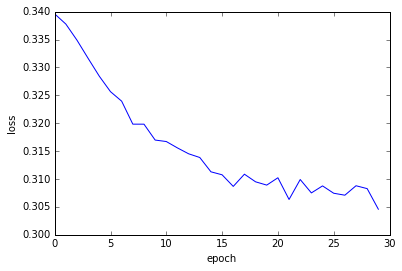

In [90]:
### Overfit model on small dataset
# Backpropagation with Stochastic Gradient Descent: 
overfit_model(model_5layer, x_train_subset, y_train_subset, SGD(lr = 0.1, momentum=0.9))

### Loss by Training Epoch

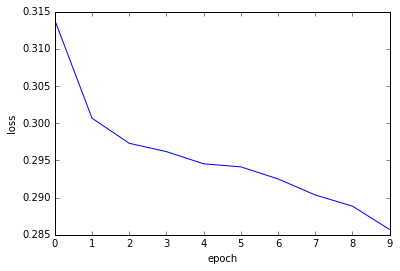

In [29]:
plt.plot(history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")


### Validation Accuracy by Training Epoch

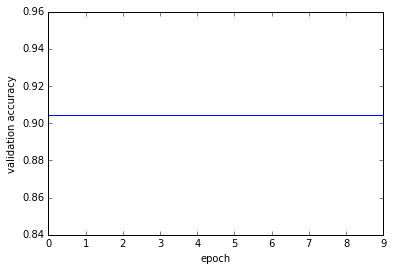

In [30]:
plt.plot(history.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("validation accuracy")

In [20]:
### Just try on full dataset first
y_pred_prob_small = model.predict(img_matrix)
print ('y pred prob shape:', y_pred_prob_small.shape)

# THIS ISNT RIGHT: need to use softmax for each. 
# y_pred_class_small = model.predict_classes(img_matrix)

# Print 1 value
print (y_pred_prob_small[5])

y pred prob shape: (5893, 20)
5893/5893 [==============================] - 4s     

- https://github.com/fchollet/keras/blob/ac1a09c787b3968b277e577a3709cd3b6c931aa5/tests/keras/test_metrics.py

In [28]:
y_pred_array = np.array(y_pred_class_small)

print (y_pred_array)
y_pred_array.shape
# classification_report(y_binary,y_pred_array)

[3 3 3 ..., 3 3 3]


(5893,)

### Model 2: Simple (2 layer) Convolutional Neural Net

#### Overfitting this model on a small subset of (training) data

- Try on a small sample of, say, 100 movies
- Make sure you can achieve zero cost (http://cs231n.github.io/neural-networks-3/#baby)


In [26]:
### Compare 1 to 2 layer

# create an empty network model
model2 = Sequential()

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

# --- input layer ---
model2.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# --- max pool ---
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))


# flatten for fully connected classification layer ( convert convolutional layer to dense layer)
model2.add(Flatten())

# --- fully connected layer ---
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation='relu'))
model2.add(Dropout(0.2))

# --- classification ---: use softmax for multil
model2.add(Dense(num_classes, activation='softmax'))

# prints out a summary of the model architecture
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 178, 126, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 89, 63, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 89, 63, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 61, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 43, 30, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 43, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20640)             0         
__________

In [38]:
### COMPILE THE MODEL
# Backpropagation with Stochastic Gradient Descent: 
sgd = SGD(lr = learning_rate, momentum=0.9)

# Backprop with Adam
adam = Adam()
model2.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

Train on 3712 samples, validate on 1591 samples
Epoch 1/30
3712/3712 [==============================] - 7s - loss: 0.2940 - acc: 0.9046 - val_loss: 0.2927 - val_acc: 0.9056

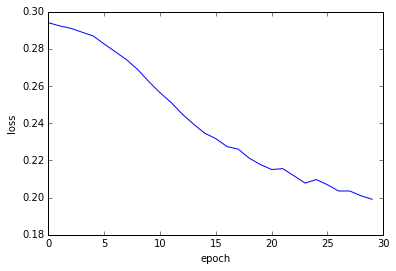

In [39]:
### FIT THE MODEL
history2_nostop = model2.fit(x_train, y_train,
                    batch_size= 128,
                    epochs= 30,
                    verbose=1,
                    validation_split=0.3)

# early_stopping2 = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, mode= 'auto')]
# history2 = model2.fit(x_train, y_train,
#                     batch_size= 128,
#                     nb_epoch = 100,
#                     verbose=1,
#                     validation_split=0.3,
#                     callbacks = early_stopping2)

plt.plot(history2_nostop.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

- Slow decline of loss by epoch suggests that learning rate may be too low
- Create model with very high learning rate

In [41]:
# Backpropagation with Stochastic Gradient Descent: 
sgd_high_lr = SGD(lr = 0.1, momentum=0.9)

model2.compile(loss ='binary_crossentropy',
              optimizer = sgd_high_lr,
              metrics = ['accuracy'])

history2_nostop_highlr = model2.fit(x_train, y_train,
                    batch_size= 128,
                    epochs= 20,
                    verbose=1,
                    validation_split=0.3)

Train on 3712 samples, validate on 1591 samples
Epoch 1/20
3712/3712 [==============================] - 7s - loss: 0.1965 - acc: 0.9225 - val_loss: 0.3652 - val_acc: 0.9014

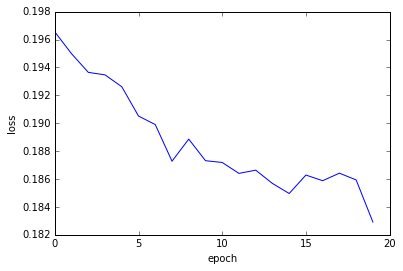

In [42]:
plt.plot(history2_nostop_highlr.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
# Predict on test

y_predict_2 = model2.predict(x_test)